# Imports and setup

In [7]:
## import important things
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import meshio


# Useful functions

## BasinMag class definition

In [8]:
## BasinMag class
class BasinMag():
    def __init__(self,B_map,RRfp,RRi,params_fp):
        self.B_map = B_map
        self.RRfp = RRfp
        self.RRi = RRi
        
        # get some parameters, do some calculations
        self.readParams(params_fp)
        self.load_revRate()
        self.calc_Brms()
        self.calc_Bmax()
        
        return
    
    def readParams(self,params_fp):
        cfg = open(params_fp, "r")

        list_of_lines = cfg.readlines()
        
        # set file paths
        self.dim_x = int(list_of_lines[0][6:-1])
        self.dim_z = int(list_of_lines[1][6:-1])
        self.dt = float(list_of_lines[2][4:-1])
        self.t_tot = float(list_of_lines[3][6:-1])
        
        return
    def make_x(self,dx):
        dom_shape = np.max(self.B_map.shape)
        
        return np.arange(-(dom_shape-1.)/2*dx,((dom_shape-1.)/2+1)*dx,dx)
        
    def calc_revRate(self):
        rev_rate = len(self.revs)/self.t_tot
        
        self.rev_rate = rev_rate
        return rev_rate
    
    def load_revRate(self):
        rev_rate = np.loadtxt(self.RRfp)
        
        if rev_rate.shape:
            self.rev_rate = rev_rate[self.RRi]
        else:
            self.rev_rate = 0
            
        return rev_rate
    
    def load_revs(self):
        rev_rate = np.loadtxt(self.RRfp)
        
        self.rev_rate = rev_rate
        return rev_rate
    
    def calc_Brms(self):
        B_rms = np.sqrt(np.mean(self.B_map**2))
        
        self.B_rms = B_rms
        return B_rms
        
    def calc_Bmax(self):
        B_max = np.amax(self.B_map)
        
        self.B_max = B_max
        return B_max
    
    def set_Susc(self,Susc):
        self.S_map = Susc
    

## Reading in maps

In [9]:
## data restructuring functions
# split BMap file into individual basins
def split_Bmaps(Bfp,dims=-1):
    Bm1 = np.loadtxt(Bfp)
    
    if dims == -1:
        if Bm1.shape[0]>30:
            dim_im = int(np.sqrt(Bm1.shape[0]))
            Bm1=Bm1.reshape(1,dim_im,dim_im)
        else:
            dim_im = int(np.sqrt(Bm1.shape[1]))
            Bm1=Bm1.reshape(Bm1.shape[0],dim_im,dim_im)#
    else:
        if Bm1.shape[0]>30:
            dim_im = int(np.sqrt(Bm1.shape[0]))
            Bm1=Bm1.reshape(1,dims[0],dims[1])
        else:
            dim_im = int(np.sqrt(Bm1.shape[1]))
            Bm1=Bm1.reshape(Bm1.shape[0],dims[0],dims[1])
    
    return Bm1

# split reversals
def split_revs(Rfp):
    Rlines = open(Rfp, "r")
    Revs = []
    
    list_of_lines = Rlines.readlines()
    for i,line in enumerate(list_of_lines):
        if line[-2]!=']':
            l1 = str.split(line[1:-1])
            l2 = str.split(list_of_lines[i+1][0:-2])
            
            Revs.append(np.array(l1+l2).astype(int))
        elif line[0]!='[':
            continue
        else:
            Revs.append(np.array(str.split(line[1:-2])).astype(int))
    
    return Revs

def readParams(params_fp):
        cfg = open(params_fp, "r")

        list_of_lines = cfg.readlines()
        
        # set file paths
        dim_x = int(list_of_lines[0][6:-1])
        dim_z = int(list_of_lines[1][6:-1])
        dt = float(list_of_lines[2][4:-1])
        t_tot = float(list_of_lines[3][6:-1])
        
        return dim_x, dim_z, dt, t_tot

# split SuscMap file into individual basins
def split_Smaps(Sfp,params_fp):
    dim_x, dim_z, dt, t_tot = readParams(params_fp)
    
    Sm1 = np.loadtxt(Sfp)
    if Sm1.shape[0]>30:
        Sm1=Sm1.reshape(1,-1,dim_x,dim_x)
    else:
        Sm1=Sm1.reshape(Sm1.shape[0],-1,dim_x,dim_x)
    return Sm1

def make_Basins(Bfp,RRfp,params_fp,**kwargs):
    Bms = split_Bmaps(Bfp,**kwargs)
    #Rms = split_revs(Rfp)
    
    Basins = []
    
    for i,Bm in enumerate(Bms):
        Basins.append(BasinMag(Bm,RRfp,i,params_fp))
        
    return Basins

## Get binned magnetic field data

In [5]:
step = 0.5
adj = 5

def get_binned_B(rev_rs, max_Bs, step, adj, output='all'):
    n_basins = max_Bs.shape[0]
    rr_bins = np.arange(0,10+step,step)
    
    frac_demag = np.zeros((n_basins,int(10/step)+1))
    n_demag = np.zeros((n_basins,int(10/step)+1))
    means = np.zeros((n_basins,int(10/step)+1))

    for br in range(n_basins):
        frac_temp = np.zeros((1,int(10/step)+1))
        n_temp = np.zeros((1,int(10/step)+1))

        rev_b = rev_rs[br,:]
        max_b = max_Bs[br,:]

        rev_b = rev_b[max_b<400]
        max_b = max_b[max_b<400]

        for ir,rr in enumerate(np.arange(0,10+step,step)):
            temp = max_b[(rev_b*1e6>rr) & (rev_b*1e6 < rr+step)]*adj/10
            
            means[:,ir] = np.nanmean(temp)
            frac_temp[:,ir] = np.sum(temp<10)/np.max([1,len(temp)])
            n_temp[:,ir] = np.sum(temp<10)
        
        frac_demag[br,:] = frac_temp
        n_demag[br,:] = n_temp
    
    if output == 'all':
        return rr_bins, means, frac_demag, n_demag
    elif  output == 'mean':
        return rr_bins, means

## Map-making demo

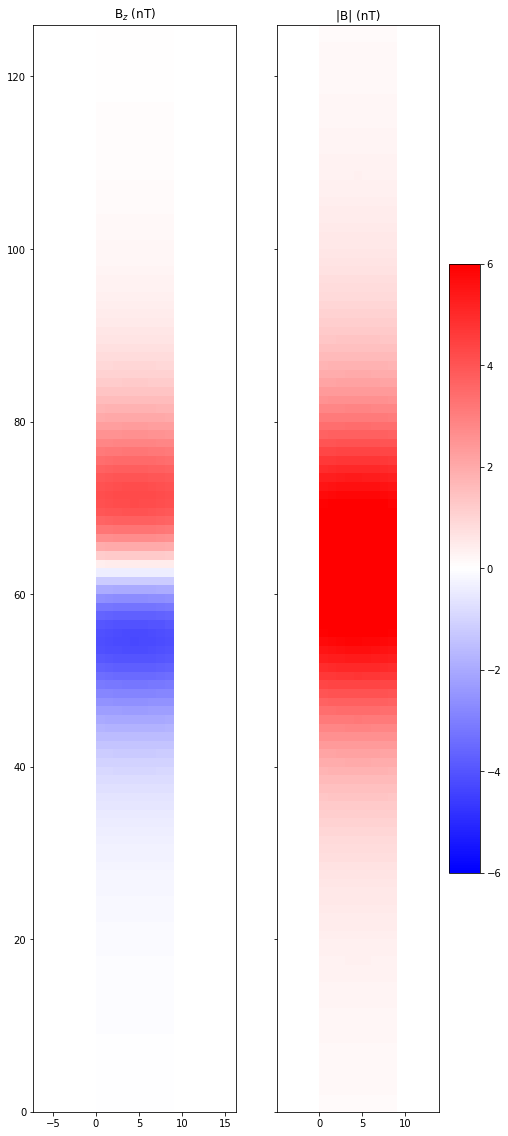

In [19]:
## plot an example magnetic field map
Bztest1 = split_Bmaps(os.getcwd()+'/600km/mag_output/BMaps/010_200km_ig6/BzMap_600km_10_15_5.txt',dims=[126,9])*5
Btest1 = split_Bmaps(os.getcwd()+'/600km/mag_output/BMaps/010_200km_ig6/BMap_600km_10_15_5.txt',dims=[126,9])*5

# plot B_z map
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(8,20),sharey=True)
pc0=ax[0].pcolormesh(Bztest1[2,:,:],cmap='bwr')
pc0.set_clim(-8,8)
ax[0].set_title('B$_z$ (nT)')
ax[0].axis('equal')

# plot |B| map
pc1=ax[1].pcolormesh(Btest1[2,:,:],cmap='bwr')
ax[1].set_title('|B| (nT)')
pc1.set_clim(-6,6)
fig.colorbar(pc1,ax=ax[1])
ax[1].axis('equal');


In [16]:
## and get the reversal rate 
revs_tmp = np.loadtxt(os.getcwd()+'/600km/mag_output/RevRates/010_200km_ig6/RR_600km_10_15_5.txt')*1e6

print(f'Mean reversal rate: {revs_tmp[2]:1.2f} Myr^-1')

Mean reversal rate: 5.01 Myr^-1


## Demo expected outputs

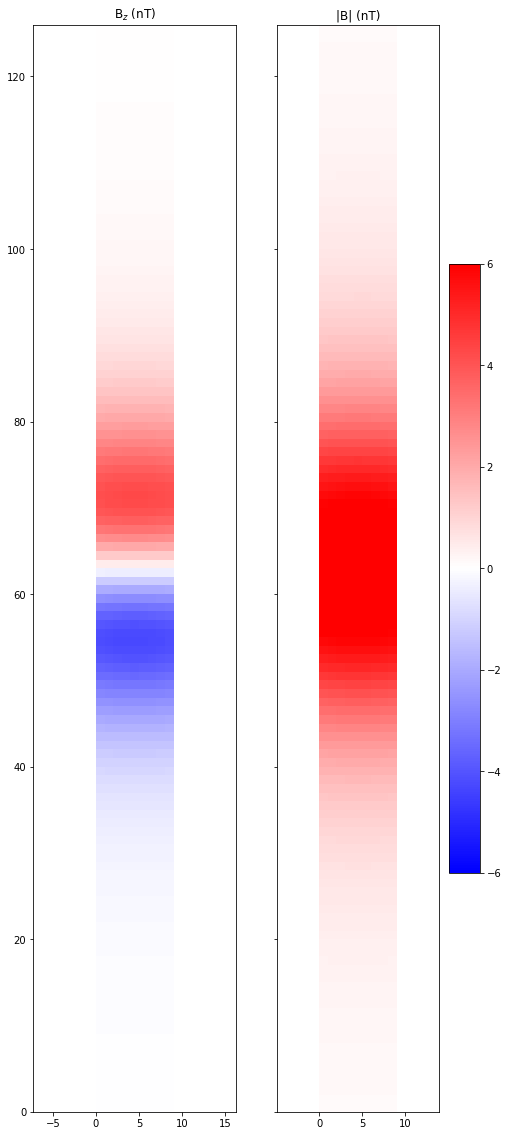

In [ ]:
## plot an example magnetic field map
Bztest1 = split_Bmaps(os.getcwd()+'/600km/mag_output_expected/BMaps/010_200km_ig6/BzMap_600km_10_15_5.txt',dims=[126,9])*5
Btest1 = split_Bmaps(os.getcwd()+'/600km/mag_output_expected/BMaps/010_200km_ig6/BMap_600km_10_15_5.txt',dims=[126,9])*5

# plot B_z map
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(8,20),sharey=True)
pc0=ax[0].pcolormesh(Bztest1[2,:,:],cmap='bwr')
pc0.set_clim(-8,8)
ax[0].set_title('B$_z$ (nT)')
ax[0].axis('equal')

# plot |B| map
pc1=ax[1].pcolormesh(Btest1[2,:,:],cmap='bwr')
ax[1].set_title('|B| (nT)')
pc1.set_clim(-6,6)
fig.colorbar(pc1,ax=ax[1])
ax[1].axis('equal');
